In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn import linear_model
from script import FrankeFunction

In [33]:
np.random.seed(42)
degree = range(18)
n = 1000
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
noise = 0.1*np.random.normal(0, 1, n)
Z = FrankeFunction(x, y) + noise

scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_scaled = scaler_x.fit_transform(x.reshape(-1,1))
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

x_combined = np.hstack((x_scaled, y_scaled))

lambda_values = [0.00001, 0.0001, 0.001, 0.01, 0.1]  

folds = 5
kfold = KFold(n_splits = folds)
scores_KFold = np.zeros((len(lambda_values), folds))

mse_ols = np.zeros((len(degree), folds))
mse_ridge = np.zeros((len(degree), len(lambda_values), folds))
mse_lasso = np.zeros((len(degree), len(lambda_values), folds))

fold_num = 0
for train_inds, test_inds in kfold.split(x):
    
    x_train, x_test = x_combined[train_inds], x_combined[test_inds]
    y_train, y_test = Z[train_inds], Z[test_inds]

    deg_num = 0
    for deg in degree:
        
        poly = PolynomialFeatures(degree=deg)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.transform(x_test)

        beta_OLS = np.linalg.inv(x_train_poly.T @ x_train_poly) @ x_train_poly.T @ y_train
        y_pred_OLS = x_test_poly @ beta_OLS
        mse_ols[deg, fold_num] = mean_squared_error(y_test, y_pred_OLS)

        lmb_num = 0
        for lmb in lambda_values:

          beta_ridge = np.linalg.inv(x_train_poly.T @ x_train_poly + lmb*np.eye(x_train_poly.shape[1])) @ x_train_poly.T @ y_train
          y_pred_ridge = x_test_poly @ beta_ridge
          mse_ridge[deg_num, lmb_num,fold_num] = mean_squared_error(y_test, y_pred_ridge)

          lasso = linear_model.Lasso(lmb, fit_intercept=False, max_iter=10000, tol=1e-4)
          lasso.fit(x_train_poly, y_train)
          y_pred_lasso = lasso.predict(x_test_poly)
          mse_lasso[deg_num, lmb_num,fold_num] = mean_squared_error(y_test, y_pred_lasso)

          lmb_num += 1
        deg_num += 1
    fold_num += 1


/home/ingar/Documents/prosa/fys4155/FYS-STK4155-Project1/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.341e+00, tolerance: 2.024e-02
  model = cd_fast.enet_coordinate_descent(
/home/ingar/Documents/prosa/fys4155/FYS-STK4155-Project1/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.416e-02, tolerance: 2.024e-02
  model = cd_fast.enet_coordinate_descent(
/home/ingar/Documents/prosa/fys4155/FYS-STK4155-Project1/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might

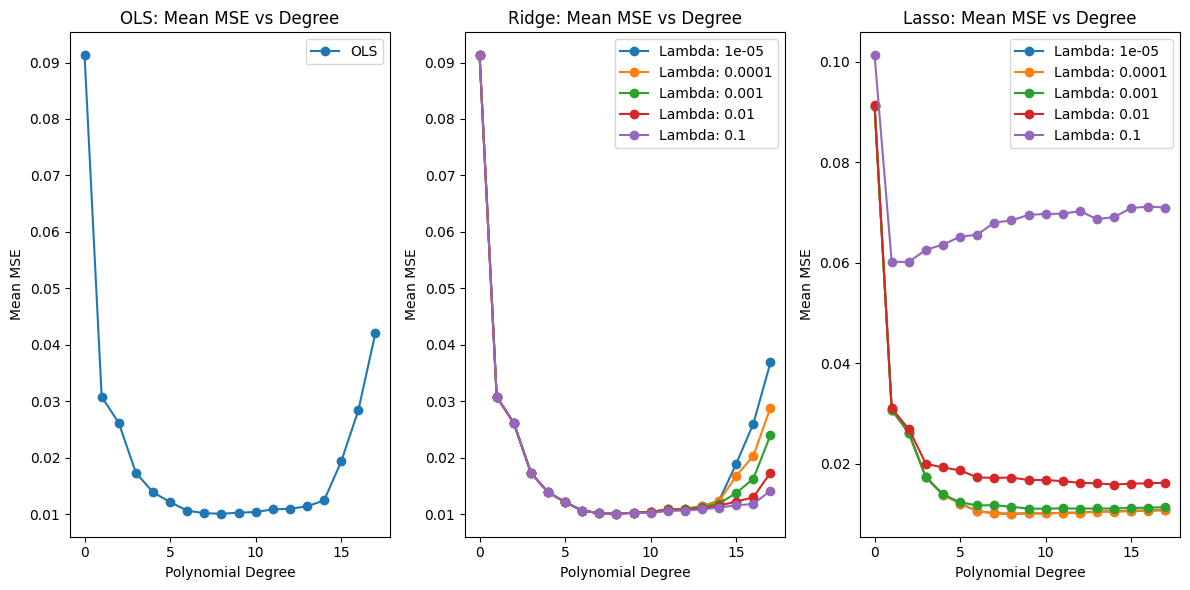

In [34]:
mean_mse_ols = np.mean(mse_ols, axis=1)
mean_mse_ridge = np.mean(mse_ridge, axis=2)
mean_mse_lasso = np.mean(mse_lasso, axis=2)

# Plotting OLS results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(degree, mean_mse_ols, label='OLS', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean MSE')
plt.title('OLS: Mean MSE vs Degree')
plt.legend()

# Plotting Ridge results
plt.subplot(1, 3, 2)
for i, lam in enumerate(lambda_values):
    plt.plot(degree, mean_mse_ridge[:, i], label=f'Lambda: {lam}', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean MSE')
plt.title('Ridge: Mean MSE vs Degree')
plt.legend()

# Plotting Lasso results
plt.subplot(1, 3, 3)
for i, lam in enumerate(lambda_values):
    plt.plot(degree, mean_mse_lasso[:, i], label=f'Lambda: {lam}', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean MSE')
plt.title('Lasso: Mean MSE vs Degree')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [35]:
min_ols_index = np.argmin(mean_mse_ols)
best_ols_degree = degree[min_ols_index]
print('Best degree for OLS: ' + str(best_ols_degree))

min_ridge_index = np.unravel_index(np.argmin(mean_mse_ridge), mean_mse_ridge.shape)
best_ridge_degree = degree[min_ridge_index[0]]
best_ridge_lambda = lambda_values[min_ridge_index[1]]
print('Best degree for Ridge: ' + str(best_ridge_degree))
print('Best lambda for Ridge: ' + str(best_ridge_lambda))


min_lasso_index = np.unravel_index(np.argmin(mean_mse_lasso), mean_mse_lasso.shape)
best_lasso_degree = degree[min_lasso_index[0]]
best_lasso_lambda = lambda_values[min_lasso_index[1]]
print('Best degree for Lasso: ' + str(best_lasso_degree))
print('Best lambda for Lasso: ' + str(best_lasso_lambda))


Best degree for OLS: 8
Best degree for Ridge: 8
Best lambda for Ridge: 0.1
Best degree for Lasso: 8
Best lambda for Lasso: 1e-05


In [36]:
x_train, x_test, y_train, y_test = train_test_split(x_combined, Z, test_size=0.2)

**Final train and test for OLS**

In [37]:
poly = PolynomialFeatures(degree=best_ols_degree)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

beta_OLS = np.linalg.inv(x_train_poly.T @ x_train_poly) @ x_train_poly.T @ y_train

y_pred_OLS_train = x_train_poly @ beta_OLS
y_pred_OLS_test = x_test_poly @ beta_OLS

mse_ols_train = mean_squared_error(y_train, y_pred_OLS_train)
mse_ols_test = mean_squared_error(y_test, y_pred_OLS_test)

print('OLS MSE for train data: ' + str(mse_ols_train))
print('OLS MSE for test data: ' + str(mse_ols_test))


OLS MSE for train data: 0.009124356747063224
OLS MSE for test data: 0.009685610343853348


**Final train and test for Ridge**

In [38]:
poly = PolynomialFeatures(degree=best_ridge_degree)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)


beta_ridge = np.linalg.inv(x_train_poly.T @ x_train_poly + best_ridge_lambda*np.eye(x_train_poly.shape[1])) @ x_train_poly.T @ y_train
y_pred_ridge_train = x_train_poly @ beta_ridge
y_pred_ridge_test = x_test_poly @ beta_ridge

mse_ridge_train = mean_squared_error(y_train, y_pred_ridge_train)
mse_ridge_test = mean_squared_error(y_test, y_pred_ridge_test)

print('Ridge MSE for train data: ' + str(mse_ridge_train))
print('Ridge MSE for test data: ' + str(mse_ridge_test))


Ridge MSE for train data: 0.00913375485430768
Ridge MSE for test data: 0.009711572306986115


In [53]:
poly = PolynomialFeatures(degree=best_lasso_degree)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)


lasso = linear_model.Lasso(best_lasso_lambda, fit_intercept=False)
lasso.fit(x_train_poly, y_train)
y_pred_lasso_train = lasso.predict(x_train_poly)
y_pred_lasso_test = lasso.predict(x_test_poly)

mse_lasso_train = mean_squared_error(y_train, y_pred_lasso_train)
mse_lasso_test = mean_squared_error(y_test, y_pred_lasso_test)

print('Lasso MSE for train data: ' + str(mse_lasso_train))
print('Lasso MSE for test data: ' + str(mse_lasso_test))

Lasso MSE for train data: 0.009436771691888552
Lasso MSE for test data: 0.010088096573786705


/home/ingar/Documents/prosa/fys4155/FYS-STK4155-Project1/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.682e+00, tolerance: 2.033e-02
  model = cd_fast.enet_coordinate_descent(
